In [ ]:
%reset -f

In [ ]:
%pwd

In [ ]:
%%javascript
document.addEventListener('keydown', function(e) {
  if (e.key === 'F12') {
    e.preventDefault()
    if (document.fullscreenElement) {
      document.exitFullscreen();
    } else {
      document.documentElement.requestFullscreen();
    }
  }
});


In [1]:
%reset -f
import pandas as pd
import arcpy
import os
from IPython.display import display

myProject = 'MyProject1'
projDIR = r'C:\Users\fullh\Documents\ArcGIS\Projects\{}'.format(myProject)
dataDIR = r'C:\Users\fullh\Documents\ArcGIS\Projects\{}\Data'.format(myProject)
gdbDIR = r'C:\Users\fullh\Documents\ArcGIS\Projects\{}\{}.gdb'.format(myProject, myProject)

arcpy.env.overwriteOutput = True

if os.path.exists(os.path.join(projDIR, 'schema.ini')):
  os.remove(os.path.join(projDIR, 'schema.ini'))

for f in os.listdir(projDIR):
  if 'RasterToNetCD' in f:
    os.remove(os.path.join(projDIR, f))

arcpy.management.Delete(os.path.join(gdbDIR, 'clip_raster'))
arcpy.management.Delete(os.path.join(gdbDIR, 'NoData_Composite'))
arcpy.management.Delete(os.path.join(gdbDIR, 'Filled_Composite'))
arcpy.management.Delete(os.path.join(gdbDIR, 'FloatIsoCluster'))
arcpy.management.Delete(os.path.join(gdbDIR, 'RasterToPoint'))
arcpy.management.Delete(os.path.join(gdbDIR, 'ForbsandGrass'))
arcpy.management.Delete(os.path.join(gdbDIR, 'us_eco_l3'))
arcpy.management.Delete(os.path.join(gdbDIR, 'us_eco_l4'))

data_files = os.listdir(dataDIR)

input_string = ';'.join(data_files)
input_list = input_string.split(';')

print('ArcPy imported')

ArcPy imported


In [ ]:
#FEATURES AND RASTERS FOR CLIPPING, ZONAL STATS
#Creates shapefile of 4 states footprint
#Clips us_eco_l4.shp and us_eco_l3.shp
#Creates rasters of l3 and l4 polygons
#Creates latitude map

arcpy.env.workspace = dataDIR

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['CCSM4_1974_2013_ero.tif'],
    input_names=['raster'],
    expression='raster >= 0'
  )
output_raster.save(os.path.join(gdbDIR, 'clip_raster'))

arcpy.env.workspace = gdbDIR

with arcpy.EnvManager(outputZFlag='Disabled', outputMFlag='Disabled'):
  arcpy.conversion.RasterToPolygon(
    in_raster='clip_raster',
    out_polygon_features=os.path.join(gdbDIR, 'clip_shape'),
    simplify='SIMPLIFY',
    raster_field='Value',
    create_multipart_features='SINGLE_OUTER_PART',
    max_vertices_per_feature=None
  )

arcpy.management.Project(
  in_dataset=os.path.join(projDIR, 'us_eco_l4', 'us_eco_l4_no_st.shp'),
  out_dataset='us_eco_l4',
  out_coor_system='GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]',
  transform_method='WGS_1984_(ITRF00)_To_NAD_1983',
  in_coor_system='PROJCS["USA_Contiguous_Albers_Equal_Area_Conic_USGS_version",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers"],PARAMETER["False_Easting",0.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-96.0],PARAMETER["Standard_Parallel_1",29.5],PARAMETER["Standard_Parallel_2",45.5],PARAMETER["Latitude_Of_Origin",23.0],UNIT["Meter",1.0]]',
  preserve_shape='NO_PRESERVE_SHAPE',
  max_deviation=None,
  vertical='NO_VERTICAL'
)

arcpy.management.Project(
  in_dataset=os.path.join(projDIR, 'us_eco_l3', 'us_eco_l3.shp'),
  out_dataset='us_eco_l3',
  out_coor_system='GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]',
  transform_method='WGS_1984_(ITRF00)_To_NAD_1983',
  in_coor_system='PROJCS["USA_Contiguous_Albers_Equal_Area_Conic_USGS_version",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers"],PARAMETER["False_Easting",0.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-96.0],PARAMETER["Standard_Parallel_1",29.5],PARAMETER["Standard_Parallel_2",45.5],PARAMETER["Latitude_Of_Origin",23.0],UNIT["Meter",1.0]]',
  preserve_shape='NO_PRESERVE_SHAPE',
  max_deviation=None,
  vertical='NO_VERTICAL'
)

arcpy.analysis.Clip(
  in_features='us_eco_l4',
  clip_features='clip_shape',
  out_feature_class='us_eco_l4_clip',
  cluster_tolerance=None
)

arcpy.analysis.Clip(
  in_features='us_eco_l3',
  clip_features='clip_shape',
  out_feature_class='us_eco_l3_clip',
  cluster_tolerance=None
)

arcpy.conversion.PolygonToRaster(
    in_features='us_eco_l4_clip',
    value_field='US_L4CODE',
    out_rasterdataset='us_eco_l4_raster',
    cell_assignment='CELL_CENTER',
    priority_field='NONE',
    cellsize='clip_raster',
    build_rat='BUILD'
)

arcpy.conversion.PolygonToRaster(
    in_features='us_eco_l3_clip',
    value_field='US_L3CODE',
    out_rasterdataset='us_eco_l3_raster',
    cell_assignment='CELL_CENTER',
    priority_field='NONE',
    cellsize='clip_raster',
    build_rat='BUILD'
)

arcpy.conversion.RasterToPoint(
  in_raster='us_eco_l3_raster',
  out_point_features='RasterToPoint',
  raster_field='Value'
)

arcpy.management.AddXY(
  in_features='RasterToPoint'
)

arcpy.conversion.PointToRaster(
  in_features='RasterToPoint',
  value_field='POINT_Y',
  out_rasterdataset='Latitude',
  cell_assignment='MOST_FREQUENT',
  priority_field='NONE',
  cellsize='clip_raster',
  build_rat='DO_NOT_BUILD'
)


In [ ]:
#Runs principle component tool to get
#initial information from output files.

input_string = uncorr_input_string

arcpy.env.workspace = dataDIR

with arcpy.EnvManager(extent='MAXOF'):
  arcpy.management.CompositeBands(
    in_rasters=input_string,
    out_raster=os.path.join(gdbDIR, 'CompositeBands')
  )

arcpy.env.workspace = gdbDIR

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['CompositeBands'],
    input_names=['raster'],
    expression='raster * 1'
  )
output_raster.save(os.path.join(gdbDIR, 'NoData_Composite'))

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['NoData_Composite'],
    input_names=['raster'],
    expression='Con(IsNull(raster),1,raster)'
  )
output_raster.save(os.path.join(gdbDIR, 'Filled_Composite'))

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.sa.ExtractByMask(
    in_raster='Filled_Composite',
    in_mask_data='clip_shape',
    extraction_area='INSIDE',
    analysis_extent='-120.004083333317 31.3333333333001 -102.995916734683 42.004083290617 GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]'
  )
output_raster.save(os.path.join(gdbDIR, 'Extract_Composite'))

with arcpy.EnvManager(scratchWorkspace=projDIR):
  out_multiband_raster = arcpy.sa.PrincipalComponents(
    in_raster_bands='Extract_Composite',
    number_components=5,
    out_data_file='pca_info.txt'
  )
out_multiband_raster.save(os.path.join(gdbDIR, 'Princip_Composite'))

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['Princip_Composite'],
    input_names=['raster'],
    expression='Con(IsNull(raster),1,raster)'
  )
output_raster.save(os.path.join(gdbDIR, 'Filled_Composite'))

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.sa.ExtractByMask(
    in_raster='Filled_Composite',
    in_mask_data='clip_shape',
    extraction_area='INSIDE',
    analysis_extent='-120.004083333317 31.3333333333001 -102.995916734683 42.004083290617 GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]'
  )
output_raster.save(os.path.join(gdbDIR, 'Princip_Composite'))

print('DONE')


In [ ]:
#Prints correlation matrix

pca_info_path = 'pca_info.txt'
input_list = uncorr_input_list

with open(os.path.join(projDIR, pca_info_path)) as f:
  lines = f.readlines()

for i, line in enumerate(lines):
  if 'CORRELATION MATRIX' in line:
    hdr_line_idx = i
    for j, l in enumerate(lines[hdr_line_idx:]):
      if '#  ========' in l:
        ftr_line_idx = hdr_line_idx + j
        break
    break

start_idx = hdr_line_idx + 4
end_idx = ftr_line_idx - 1

corr_m_lines = lines[start_idx:end_idx + 1]

corr_data = []
for l in corr_m_lines:
  row = l.split()
  corr_data.append([float(x) for x in row[1:]])

corr_df = pd.DataFrame(corr_data)

def vif_fn(x):
  if x != 1:
    vif = (1)/(1 - x**2)
  else:
    vif = 0
  return vif

vif_df = corr_df.map(vif_fn)

high_value_mask = vif_df >= 5
stacked_mask = high_value_mask.stack()
result = stacked_mask[stacked_mask]

matrix_index_col_list = []
for (index, col), _ in result.items():
  matrix_index_col_list.append([index, col])

index_col_list = []
for l in matrix_index_col_list:
  if l not in index_col_list and l.reverse() not in index_col_list:
    index_col_list.append(l)

print('VIF FACTORS >=5:')  
for index, col in index_col_list:
  print(f"Index: {index}, Column: {col}, Value: {vif_df.loc[index, col]}")
  print(input_list[index], input_list[col])



In [2]:
#Removal of multicolinearity from inputs with VIF > 5 EXCEPT FOR DEM_Elev.tif

removal_choices = ['pmomx_1974_2013.tif', 'CCSM4_1974_2013_pet.tif', 'POL_theta_s.tif', 'POL_theta_r.tif', 'RAP_afg.tif', 'RAP_pfg.tif', 'RAP_tre.tif', 'tmean_1974_2013.tif']

uncorr_input_list = []
for l in input_list:
  if l not in removal_choices:
    uncorr_input_list.append(l)

uncorr_input_string = ';'.join(uncorr_input_list)

var_labels = [s[:-4] for s in input_list]
df = pd.DataFrame(data=var_labels, index=list(range(1, len(var_labels)+1)))
print('All Variables:')
display(df)

var_labels = [s[:-4] for s in uncorr_input_list]
df = pd.DataFrame(data=var_labels, index=list(range(1, len(var_labels)+1)))
print('Uncorrelated Variables:')
display(df)

varidx_varlbl_key = df.to_dict()[0]
print(varidx_varlbl_key)


All Variables:


,0
1,accm_1974_2013
2,CCSM4_1974_2013_consec
3,CCSM4_1974_2013_ero
4,CCSM4_1974_2013_ndays
5,CCSM4_1974_2013_pet
6,CCSM4_1974_2013_swe
7,DEM_Elev
8,DEM_Slope
9,pmomn_1974_2013
10,pmomx_1974_2013


Uncorrelated Variables:


,0
1,accm_1974_2013
2,CCSM4_1974_2013_consec
3,CCSM4_1974_2013_ero
4,CCSM4_1974_2013_ndays
5,CCSM4_1974_2013_swe
6,DEM_Elev
7,DEM_Slope
8,pmomn_1974_2013
9,POL_bd
10,POL_clay


{1: 'accm_1974_2013', 2: 'CCSM4_1974_2013_consec', 3: 'CCSM4_1974_2013_ero', 4: 'CCSM4_1974_2013_ndays', 5: 'CCSM4_1974_2013_swe', 6: 'DEM_Elev', 7: 'DEM_Slope', 8: 'pmomn_1974_2013', 9: 'POL_bd', 10: 'POL_clay', 11: 'POL_ksat', 12: 'POL_om', 13: 'POL_ph', 14: 'POL_sand', 15: 'POL_silt', 16: 'RAP_afgNPP', 17: 'RAP_bgr', 18: 'RAP_ltr', 19: 'RAP_pfgNPP', 20: 'RAP_shr', 21: 'RAP_shrNPP', 22: 'RAP_treNPP', 23: 'tmomn_1974_2013', 24: 'tmomx_1974_2013'}


In [ ]:
#Iso Cluster using composite as input.

input_string = uncorr_input_string

arcpy.env.workspace = dataDIR

with arcpy.EnvManager(extent='MAXOF'):
  arcpy.management.CompositeBands(
    in_rasters=input_string,
    out_raster=os.path.join(gdbDIR, 'CompositeBands')
  )

arcpy.env.workspace = gdbDIR

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['CompositeBands'],
    input_names=['raster'],
    expression='raster * 1'
  )
output_raster.save('NoData_Composite')

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['NoData_Composite'],
    input_names=['raster'],
    expression='Con(IsNull(raster),1,raster)'
  )
output_raster.save('Filled_Composite')

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.sa.ExtractByMask(
    in_raster='Filled_Composite',
    in_mask_data='clip_shape',
    extraction_area='INSIDE',
    analysis_extent='-120.004083333317 31.3333333333001 -102.995916734683 42.004083290617 GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]'
  )
output_raster.save('Extract_Composite')

with arcpy.EnvManager(scratchWorkspace=os.path.join(gdbDIR)):
  Output_classified_raster = arcpy.sa.IsoClusterUnsupervisedClassification(
    in_raster_bands='Extract_Composite',
    Number_of_classes=15,
    Minimum_class_size=20,
    Sample_interval=10,
    out_signature_file=os.path.join(projDIR, 'iso_signature.gsg')
  )
Output_classified_raster.save('FloatIsoCluster')

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  out_raster = arcpy.ia.Int(
    in_raster_or_constant='FloatIsoCluster'
  )
out_raster.save('IsoCluster')

print('DONE')


In [ ]:
#Iso Cluster using PCA as input and multidimensional raster.

input_string = uncorr_input_string

arcpy.env.workspace = dataDIR

with arcpy.EnvManager(extent='MAXOF'):
  arcpy.management.CompositeBands(
    in_rasters=input_string,
    out_raster=os.path.join(gdbDIR, 'CompositeBands')
  )

arcpy.env.workspace = gdbDIR

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['CompositeBands'],
    input_names=['raster'],
    expression='raster * 1'
  )
output_raster.save(os.path.join(gdbDIR, 'NoData_Composite'))

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['NoData_Composite'],
    input_names=['raster'],
    expression='Con(IsNull(raster),1,raster)'
  )
output_raster.save(os.path.join(gdbDIR, 'Filled_Composite'))

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.sa.ExtractByMask(
    in_raster='Filled_Composite',
    in_mask_data='clip_shape',
    extraction_area='INSIDE',
    analysis_extent='-120.004083333317 31.3333333333001 -102.995916734683 42.004083290617 GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]'
  )
output_raster.save(os.path.join(gdbDIR, 'Extract_Composite'))

import random
threedigits = [str(x) for x in random.sample(range(0, 10), 3)]

arcpy.md.RasterToNetCDF(
  in_raster='Extract_Composite',
  out_netCDF_file=os.path.join(projDIR, 'RasterToNetCD' + ''.join(threedigits) + '.nc'),
  variable='Extract_Composite',
  variable_units='',
  x_dimension='lon',
  y_dimension='lat',
  band_dimension='band',
  fields_to_dimensions=None,
  compression_level=0
)

arcpy.md.MakeMultidimensionalRasterLayer(
  in_multidimensional_raster=os.path.join(projDIR, 'RasterToNetCD' + ''.join(threedigits) + '.nc'),
  out_multidimensional_raster_layer='MultidimRasterLyr',
  variables='Extract_Composite',
  dimension_def='ALL',
  dimension_ranges=None,
  dimension_values=None,
  dimension='',
  start_of_first_iteration='',
  end_of_first_iteration='',
  iteration_step=None,
  iteration_unit='',
  template='-120.00833328533 31.3333333207995 -102.991666625469 42.00833331653 GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]',
  dimensionless='DIMENSIONS',
  spatial_reference=None
)

arcpy.ia.MultidimensionalPrincipalComponents(
  in_multidimensional_raster='MultidimRasterLyr',
  mode='DIMENSION_REDUCTION',
  dimension='band',
  out_pc=os.path.join(projDIR, 'MultidimRasterLyr_d_pc.crf'),
  out_loadings=os.path.join(projDIR, 'MultidimRasterLyr_d_loading.csv'),
  out_eigenvalues=os.path.join(gdbDIR, 'eigenvalues'),
  variable='Extract_Composite',
  number_of_pc='99%'
)

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  Output_classified_raster = arcpy.sa.IsoClusterUnsupervisedClassification(
    in_raster_bands=os.path.join(projDIR, 'MultidimRasterLyr_d_pc.crf'),
    Number_of_classes=15,
    Minimum_class_size=20,
    Sample_interval=10,
    out_signature_file=os.path.join(projDIR, 'iso_signature.gsg')
  )
Output_classified_raster.save(os.path.join(gdbDIR, 'IsoCluster'))

print('DONE')



In [ ]:
#ZONAL STATS TABLE EXPORT

import os

if not os.path.exists(os.path.join(projDIR, 'Zonal')):
  os.makedirs(os.path.join(projDIR, 'Zonal'))

arcpy.env.workspace = gdbDIR

arcpy.sa.ZonalHistogram(
  in_zone_data='us_eco_l3_clip',
  zone_field='US_L3CODE',
  in_value_raster='IsoCluster',
  out_table='Zonal_eco3',
  out_graph='',
  zones_as_rows='ZONES_AS_FIELDS'
)

arcpy.conversion.ExportTable(
  in_table='Zonal_eco3',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_eco3.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.sa.ZonalHistogram(
  in_zone_data='us_eco_l4_clip',
  zone_field='US_L4CODE',
  in_value_raster='IsoCluster',
  out_table='Zonal_eco4',
  out_graph='',
  zones_as_rows='ZONES_AS_FIELDS'
)

arcpy.conversion.ExportTable(
  in_table='Zonal_eco4',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_eco4.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=os.path.join(dataDIR, 'DEM_Elev.tif'),
  out_table='Zonal_elev',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_elev',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_elev.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=os.path.join(dataDIR, 'DEM_Slope.tif'),
  out_table='Zonal_slpe',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_slpe',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_slpe.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=os.path.join(dataDIR, 'accm_1974_2013.tif'),
  out_table='Zonal_accm',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_accm',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_accm.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=os.path.join(dataDIR, 'CCSM4_1974_2013_ndays.tif'),
  out_table='Zonal_nday',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_nday',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_nday.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=os.path.join(dataDIR, 'tmean_1974_2013.tif'),
  out_table='Zonal_tavg',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_tavg',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_tavg.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=os.path.join(dataDIR, 'RAP_bgr.tif'),
  out_table='Zonal_bare',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_bare',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_bare.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=os.path.join(dataDIR, 'RAP_ltr.tif'),
  out_table='Zonal_litr',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_litr',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_litr.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=os.path.join(dataDIR, 'POL_om.tif'),
  out_table='Zonal_orgm',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_orgm',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_orgm.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=os.path.join(dataDIR, 'POL_clay.tif'),
  out_table='Zonal_clay',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_clay',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_clay.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=os.path.join(dataDIR, 'POL_bd.tif'),
  out_table='Zonal_bulk',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_bulk',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_bulk.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=os.path.join(dataDIR, 'POL_ph.tif'),
  out_table='Zonal_pphh',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_pphh',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_pphh.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster='Latitude',
  out_table='Zonal_ylat',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_ylat',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_ylat.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[os.path.join(dataDIR, 'RAP_pfg.tif'), os.path.join(dataDIR, 'RAP_afg.tif')],
    input_names=['pfg', 'afg'],
    expression='pfg + afg'
  )
output_raster.save('ForbsandGrass')

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster='ForbsandGrass',
  out_table='Zonal_gras',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_gras',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_gras.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

files = [f for f in os.listdir(os.path.join(projDIR, 'Zonal')) if 'Zonal' in f and f[-4:] == '.csv' and 'eco3' not in f and 'eco4' not in f]
labels = [f.split('_')[1][:-4] for f in files]

df = pd.DataFrame()
for i, f in enumerate(files):
  idf = pd.read_csv(os.path.join(projDIR, 'Zonal', f))
  df[labels[i]] = idf['MEAN']

df['orgm'] = df['orgm'].apply(lambda x: 10**x)

#TEMPERATURE-BASED CLASS ORDER
temp_order_df = df.sort_values(by='tavg', ascending=False)
temp_order_df.index.name = 'arc_id'
df = temp_order_df.reset_index()

arcid_list = [x+1 for x in df['arc_id'].tolist()]
class_list = list(range(1, len(arcid_list)+1))
arc_temporder_key = dict(zip(class_list, arcid_list))
print(arc_temporder_key)

#https://colorswall.com/palette/176957
colors = ['#ff355e', '#fd5b78', '#ff6037', '#ff9966', '#ff9933', '#ffcc33', '#ffff66', '#ccff00', '#66ff66', '#aaf0d1', '#16d0cb', '#50bfe6', '#9c27b0', '#ee34d2', '#ff00cc']

def plot_fn():
  z = np.polyfit(x, y, deg=1)
  p = np.poly1d(z)
  ax.margins(0.25, 0.25)
  ax.plot(x, p(x), color='black', linestyle=':', linewidth=1, zorder=-999)
  ax.scatter(x, y, s=50, c=colors, edgecolor='k')
  ymin, ymax = ax.get_ylim()[0], ax.get_ylim()[1]
  xmin, xmax = ax.get_xlim()[0], ax.get_xlim()[1]
  for i in range(1, len(x)+1):
    ax.text(x[i-1] - 0.025*(xmax - xmin), y[i-1] + 0.025*(ymax - ymin), i, fontsize=9)

print('DONE')

{1: 1, 2: 2, 3: 10, 4: 3, 5: 13, 6: 11, 7: 12, 8: 4, 9: 15, 10: 7, 11: 5, 12: 8, 13: 9, 14: 14, 15: 6}
DONE


C:\Users\fullh\AppData\Local\Temp\ipykernel_66136\2858267079.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(4, 3))


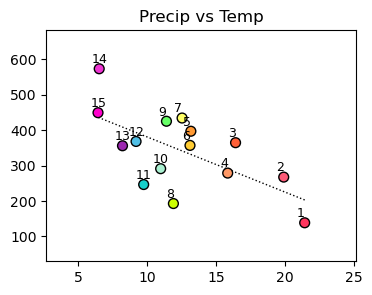

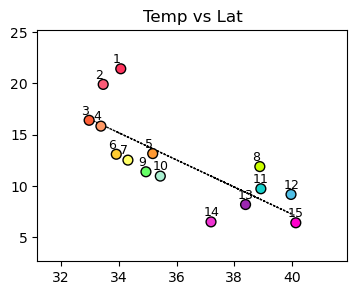

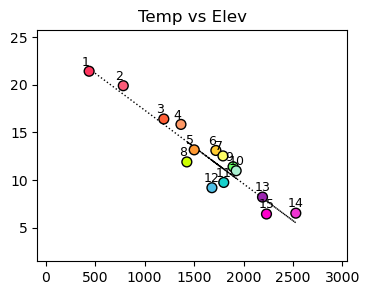

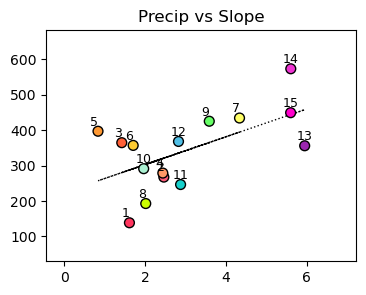

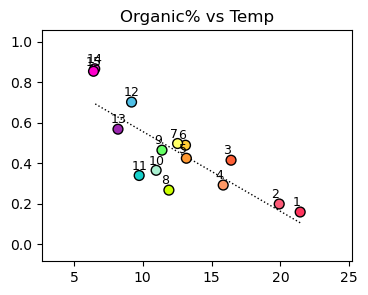

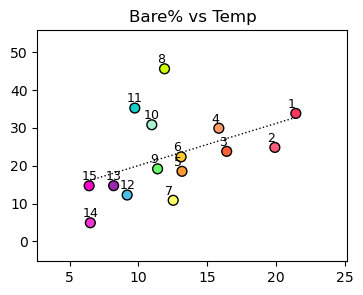

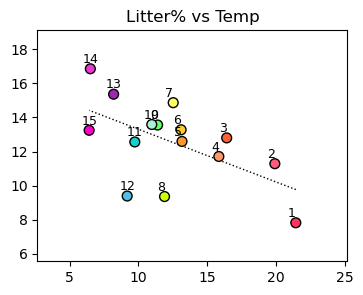

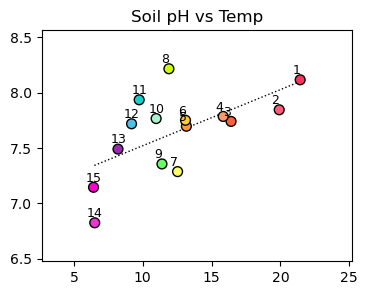

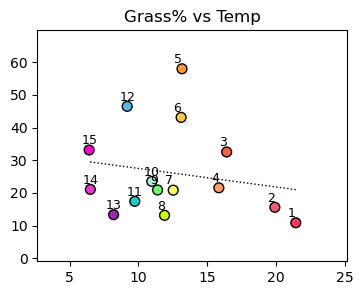

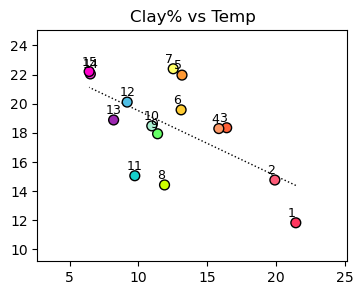

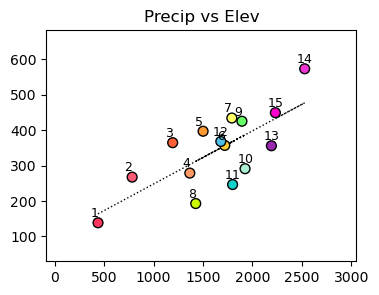

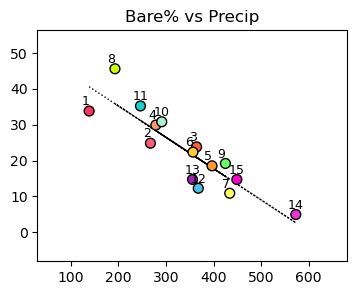

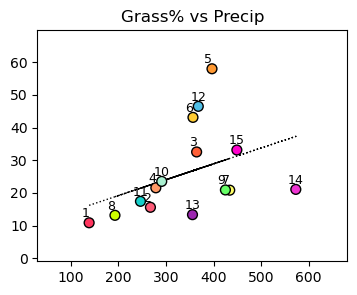

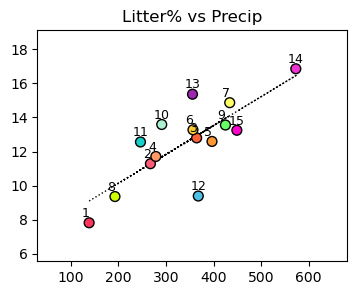

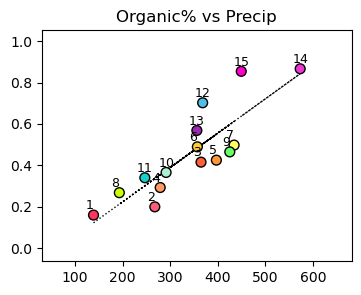

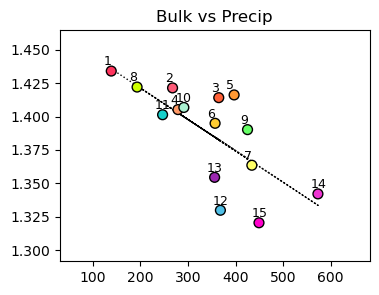

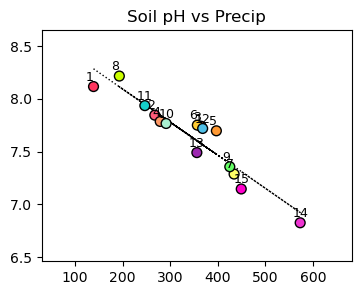

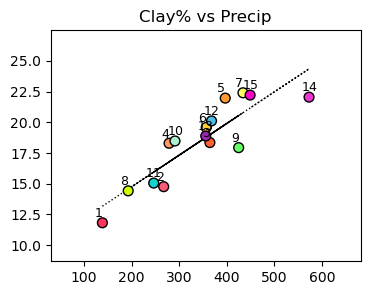

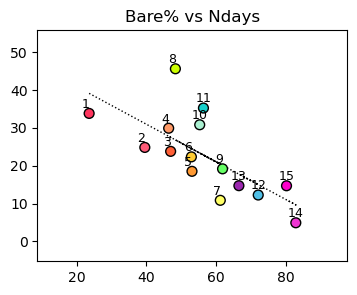

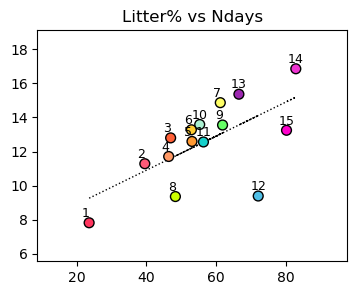

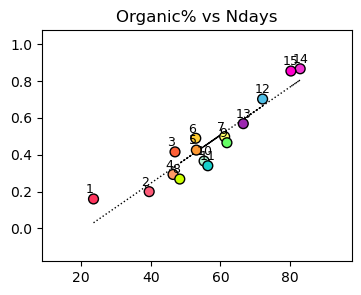

In [4]:
#ZONAL CORRELATION PLOTS

#########################################################################################

x = df['tavg']
y = df['accm']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Precip vs Temp')
plot_fn()

#########################################################################################

x = df['ylat']
y = df['tavg']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Temp vs Lat')
plot_fn()

#########################################################################################

x = df['elev']
y = df['tavg']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Temp vs Elev')
plot_fn()

#########################################################################################

x = df['slpe']
y = df['accm']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Precip vs Slope')
plot_fn()

#########################################################################################

x = df['tavg']
y = df['orgm']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Organic% vs Temp')
plot_fn()

#########################################################################################

x = df['tavg']
y = df['bare']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Bare% vs Temp')
plot_fn()

#########################################################################################

x = df['tavg']
y = df['litr']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Litter% vs Temp')
plot_fn()

#########################################################################################

x = df['tavg']
y = df['pphh']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Soil pH vs Temp')
plot_fn()

#########################################################################################

x = df['tavg']
y = df['gras']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Grass% vs Temp')
plot_fn()

#########################################################################################

x = df['tavg']
y = df['clay']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Clay% vs Temp')
plot_fn()

#########################################################################################

x = df['elev']
y = df['accm']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Precip vs Elev')
plot_fn()

#########################################################################################

x = df['accm']
y = df['bare']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Bare% vs Precip')
plot_fn()

#########################################################################################

x = df['accm']
y = df['gras']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Grass% vs Precip')
plot_fn()

#########################################################################################

x = df['accm']
y = df['litr']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Litter% vs Precip')
plot_fn()

#########################################################################################

x = df['accm']
y = df['orgm']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Organic% vs Precip')
plot_fn()

#########################################################################################

x = df['accm']
y = df['bulk']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Bulk vs Precip')
plot_fn()

#########################################################################################

x = df['accm']
y = df['pphh']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Soil pH vs Precip')
plot_fn()

#########################################################################################

x = df['accm']
y = df['clay']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Clay% vs Precip')
plot_fn()

#########################################################################################

x = df['nday']
y = df['bare']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Bare% vs Ndays')
plot_fn()

#########################################################################################

x = df['nday']
y = df['litr']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Litter% vs Ndays')
plot_fn()

#########################################################################################

x = df['nday']
y = df['orgm']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Organic% vs Ndays')
plot_fn()




In [5]:
#ITEMIZED LIST OF % AREA OF ECOREGIONS IN ISO CLASSES.

import pandas as pd

arcpy.env.workspace = gdbDIR

arcpy.conversion.ExportTable(
  in_table='us_eco_l3_clip',
  out_table=os.path.join(projDIR, 'us_eco_l3_clip.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.conversion.ExportTable(
  in_table='us_eco_l4_clip',
  out_table=os.path.join(projDIR, 'us_eco_l4_clip.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

df = pd.read_csv(os.path.join(projDIR, 'Zonal', 'Zonal_eco3.csv'))
total_n = df.iloc[:, 1:].sum().sum()
eco_df = pd.read_csv(os.path.join(projDIR, 'us_eco_l3_clip.csv'))
ecoid_econame_key = dict(zip(eco_df['US_L3CODE'].tolist(), eco_df['US_L3NAME'].tolist()))
for i, row in df.iterrows():
  #print('Class Num: ', i+1)
  row_n = row[1:].sum()
  sorted_row = row[1:].sort_values(ascending=False)
  top_three = sorted_row[:3].divide(row_n).multiply(100.0)
  top_index = top_three.index
  for j, eco_id in enumerate(top_index):
    #print(top_three[j], ecoid_econame_key[int(eco_id.split('_')[-1])])
    pass

df = pd.read_csv(os.path.join(projDIR, 'Zonal', 'Zonal_eco4.csv'))
total_n = df.iloc[:, 1:].sum().sum()
eco_df = pd.read_csv(os.path.join(projDIR, 'us_eco_l4_clip.csv'))
ecoid_econame_key = dict(zip(eco_df['US_L4CODE'].tolist(), eco_df['US_L4NAME'].tolist()))
for i, row in df.iterrows():
  print('Class Num: ', i+1)
  row_n = row[1:].sum()
  sorted_row = row[1:].sort_values(ascending=False)
  top_five = sorted_row[:5].divide(row_n).multiply(100.0)
  top_index = top_five.index
  for j, eco_id in enumerate(top_index):
    print(top_five[j], ecoid_econame_key[eco_id.split('_')[-1]])
    pass


Class Num:  1
33.652677870606325 Central Sonoran/Colorado Desert Basins
13.769448297366752 Eastern Mojave Basins
10.220100426867951 Central Sonoran/Colorado Desert Mountains
9.07175037364386 Arid Valleys and Canyonlands
7.449222068105329 Gila/Salt Intermediate Basins
Class Num:  2
37.55409170872016 Arizona Upland/Eastern Sonoran Basins
33.39882121807465 Arizona Upland/Eastern Sonoran Mountains
8.712456822938737 Eastern Mojave Basins
4.94882956456977 Eastern Mojave Low Ranges and Arid Footslopes
3.1716681433542635 Gila/Salt Intermediate Basins
Class Num:  3
25.549470235962534 Chihuahuan Basins and Playas
14.264216614628653 Apachian Valleys and Low Hills
10.610636228694274 Low Mountains and Bajadas
8.095408711675283 Chihuahuan Desert Grasslands
6.34283666888468 Madrean Basin Grasslands
Class Num:  4
12.276455227440573 Lahontan Salt Shrub Basin
11.480687074421283 Shadscale-Dominated Saline Basins
10.957713332650169 Tonopah Basin
9.505754477962663 Salt Deserts
7.98842390555377 Arid Canyonl

C:\Users\fullh\AppData\Local\Temp\ipykernel_66136\3539988521.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(top_five[j], ecoid_econame_key[eco_id.split('_')[-1]])


{1: 'accm_1974_2013', 2: 'CCSM4_1974_2013_consec', 3: 'CCSM4_1974_2013_ero', 4: 'CCSM4_1974_2013_ndays', 5: 'CCSM4_1974_2013_swe', 6: 'DEM_Elev', 7: 'DEM_Slope', 8: 'pmomn_1974_2013', 9: 'POL_bd', 10: 'POL_clay', 11: 'POL_ksat', 12: 'POL_om', 13: 'POL_ph', 14: 'POL_sand', 15: 'POL_silt', 16: 'RAP_afgNPP', 17: 'RAP_bgr', 18: 'RAP_ltr', 19: 'RAP_pfgNPP', 20: 'RAP_shr', 21: 'RAP_shrNPP', 22: 'RAP_treNPP', 23: 'tmomn_1974_2013', 24: 'tmomx_1974_2013'}


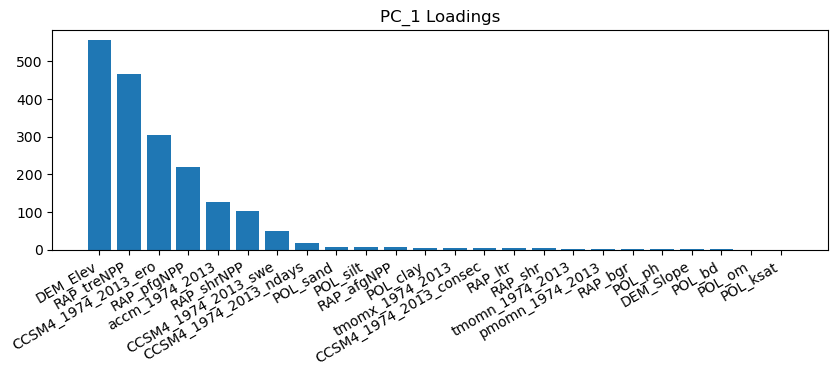

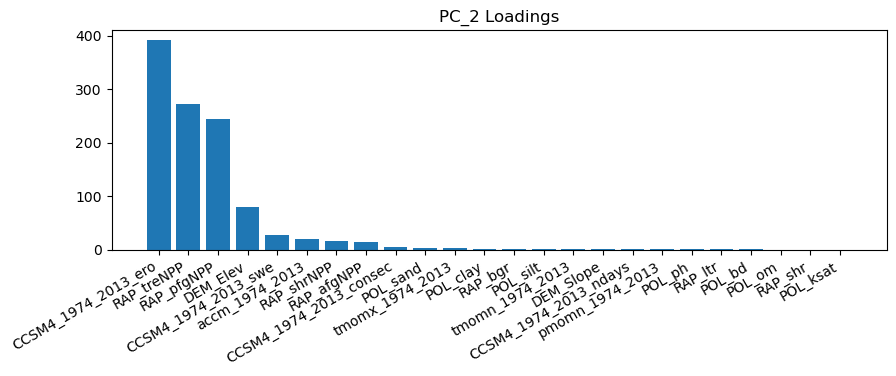

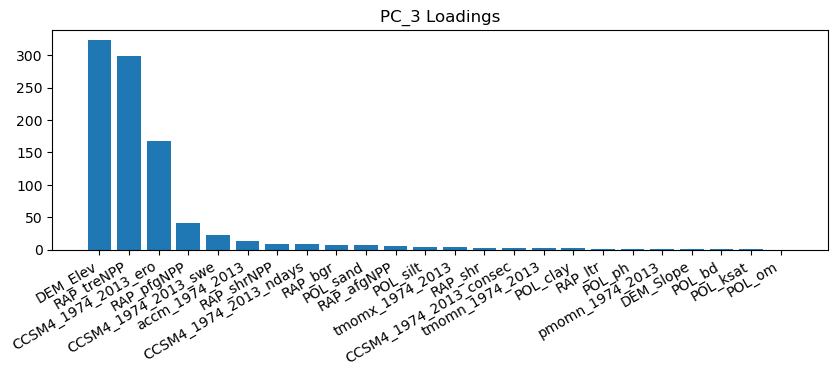

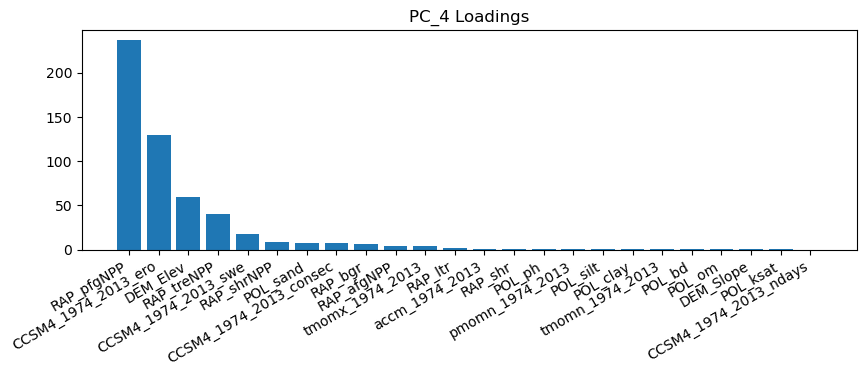

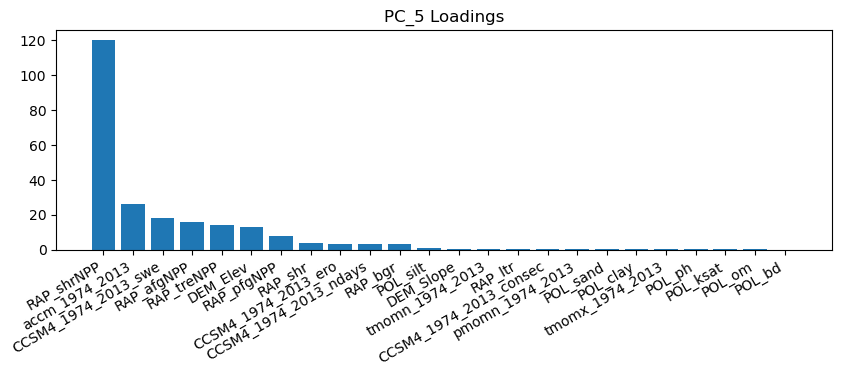

In [8]:
#PLOT PCA LOADING
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

df = pd.read_csv(os.path.join(projDIR, 'MultidimRasterLyr_d_loading.csv'))

print(varidx_varlbl_key)

for i in range(1, 6):
  col_str = 'PC_{}'.format(i)
  sorted_df = df.sort_values(by=col_str, key=abs, ascending=False)
  sorted_idx = [x+1 for x in sorted_df.index.to_list()]
  x_labels = [varidx_varlbl_key[sorted_idx[j]] for j in range(len(sorted_idx))]
  y = sorted_df[col_str].to_list()
  y_abs = [abs(n) for n in y]
  fig, ax = plt.subplots(figsize=(8.5, 3))
  ax.tick_params(axis='x', labelrotation=45)
  fig.tight_layout()
  fig.autofmt_xdate()
  ax.set_title('PC_{} '.format(i) + 'Loadings')
  ax.bar(x_labels, y_abs)
  